<a href="https://colab.research.google.com/github/sukawatd/sukawatd/blob/main/Signal_Processing_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
In this Notebook, we are going to setup the framework for using a feature-based, [supervised learning](https://en.wikipedia.org/wiki/Supervised_learning) model to classify our gesture sets.  in this Notebook you will begin to learn:
- How to exploit the preprocess and signal processing to clean the signal and select the features
- How to setup a classification experiment using Scikit-learn (Basic Example) 


## Set up environment and import libraries

In [ ]:
from scipy.fftpack import fft
from scipy.signal import welch
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## Signal Processing

Periodic signals are composed of sinusoidal waveforms of one or more frequencies. Is there a way to extract and measure the strength of these underlying frequencies? Yes! This is called Fourier analysis, a family of mathematical techniques to transform a signal from the time domain to the frequency domain. 

### Fast Fourier Transform

This function would transform signal in Time-domain to frequency domain with library in scipy

In [ ]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

### Power Spectral Density 
This function simply looks the power density distribution in frequency domain. It's may seen the characteristic between the classes

In [ ]:
def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values


### Autocorrelation
The auto-correlation function calculates the correlation of a signal with a time-delayed version of itself

In [ ]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values

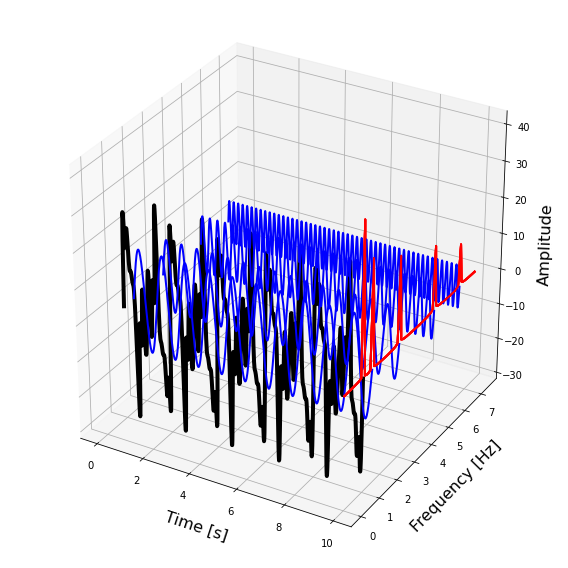

In [ ]:
t_n = 10
N = 1000
T = t_n / N
f_s = 1/T

x_value = np.linspace(0,t_n,N)
amplitudes = [4, 6, 8, 10, 14]
frequencies = [6.5, 5, 3, 1.5, 1]
y_values = [amplitudes[ii]*np.sin(2*np.pi*frequencies[ii]*x_value) for ii in range(0,len(amplitudes))]
composite_y_value = np.sum(y_values, axis=0)

f_values, fft_values = get_fft_values(composite_y_value, T, N, f_s)

colors = ['k', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("\nTime [s]", fontsize=16)
ax.set_ylabel("\nFrequency [Hz]", fontsize=16)
ax.set_zlabel("\nAmplitude", fontsize=16)

y_values_ = [composite_y_value] + list(reversed(y_values))
frequencies = [1, 1.5, 3, 5, 6.5]

for ii in range(0,len(y_values_)):
    signal = y_values_[ii]
    color = colors[ii]
    length = signal.shape[0]
    x=np.linspace(0,10,1000)
    try:
        y=np.array([frequencies[ii]]*length)
    except:
        continue
    z=signal

    if ii == 0:
        linewidth = 4
    else:
        linewidth = 2
    ax.plot(list(x), list(y), zs=list(z), linewidth=linewidth, color=color)

    x=[10]*75
    y=f_values[:75]
    z = fft_values[:75]*3
    ax.plot(list(x), list(y), zs=list(z), linewidth=2, color='red')
    
    plt.tight_layout()
plt.show()

## Download and Extract the gesture dataset

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip

--2022-11-05 02:04:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip 100%[===================>]  58.17M  44.1MB/s    in 1.3s    

2022-11-05 02:04:05 (44.1 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314/60999314]



In [ ]:
!unzip -qq 'UCI HAR Dataset.zip'

## Read and label signal

In [ ]:
def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
        data = np.array(data, dtype=np.float32)
    return data

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return np.array(activities)

INPUT_FOLDER_TRAIN = '/content/UCI HAR Dataset/train/Inertial Signals/'
INPUT_FOLDER_TEST = '/content/UCI HAR Dataset/test/Inertial Signals/'

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

train_signals, test_signals = [], []

for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))

for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))


LABELFILE_TRAIN = '/content/UCI HAR Dataset/train/y_train.txt'
LABELFILE_TEST = '/content/UCI HAR Dataset/test/y_test.txt'
train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

## Create plot function to visualise graph 

In [ ]:
def _plot(x, mph, mpd, threshold, edge, valley, ax, ind, title):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))
            no_ax = True
        else:
            no_ax = False

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        if title:
            if not isinstance(title, str):
                mode = 'Valley detection' if valley else 'Peak detection'
                title = "%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"% \
                        (mode, str(mph), mpd, str(threshold), edge)
            ax.set_title(title)
        # plt.grid()
        if no_ax:
            plt.show()

## Create Detect Peak function

In [ ]:
# Copied From http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
# Thank you Marcos Duarte

def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.
    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).
    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.
    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 
    See this IPython Notebook [1]_.
    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)
    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)
    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)
    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)
    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)
    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


## Create Visualisation according to signal processing technique with Gesture dataset

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral

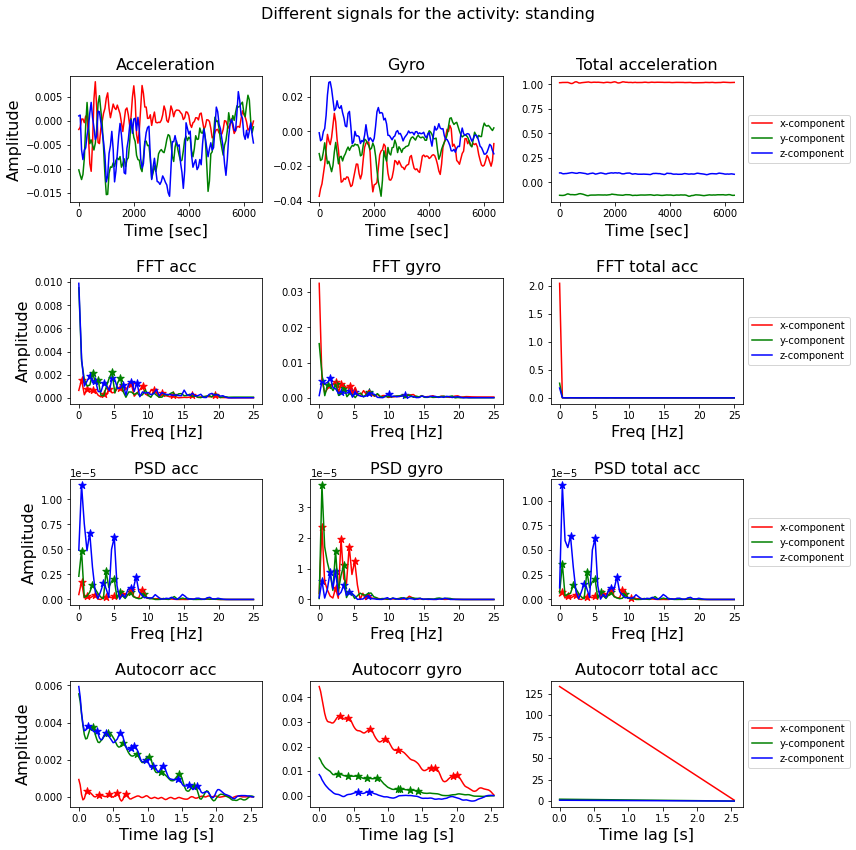

In [ ]:
def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = [f_s * kk for kk in range(0,len(y_values))]
    return x_values, y_values

####

labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']
suptitle = "Different signals for the activity: {}"

xlabels = ['Time [sec]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [s]']
ylabel = 'Amplitude'
axtitles = [['Acceleration', 'Gyro', 'Total acceleration'],
            ['FFT acc', 'FFT gyro', 'FFT total acc'],
            ['PSD acc', 'PSD gyro', 'PSD total acc'],
            ['Autocorr acc', 'Autocorr gyro', 'Autocorr total acc']
           ]

activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

list_functions = [get_values, get_fft_values, get_psd_values, get_autocorr_values]

N = 128
f_s = 50
t_n = 2.56
T = t_n / N

signal_no = 3
signals = train_signals[signal_no, :, :]
label = train_labels[signal_no]
activity_name = activities_description[label]

f, axarr = plt.subplots(nrows=4, ncols=3, figsize=(12,12))
f.suptitle(suptitle.format(activity_name), fontsize=16)

for row_no in range(0,4):
    for comp_no in range(0,9):
        col_no = comp_no // 3
        plot_no = comp_no % 3
        color = colors[plot_no]
        label = labels[plot_no]

        axtitle  = axtitles[row_no][col_no]
        xlabel = xlabels[row_no]
        value_retriever = list_functions[row_no]

        ax = axarr[row_no, col_no]
        ax.set_title(axtitle, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=16)
        if col_no == 0:
            ax.set_ylabel(ylabel, fontsize=16)

        signal_component = signals[:, comp_no]
        x_values, y_values = value_retriever(signal_component, T, N, f_s)
        ax.plot(x_values, y_values, linestyle='-', color=color, label=label)
        if row_no > 0:
            max_peak_height = 0.1 * np.nanmax(y_values)
            indices_peaks = detect_peaks(y_values, mph=max_peak_height)
            ax.scatter(x_values[indices_peaks], y_values[indices_peaks], c=color, marker='*', s=60)
        if col_no == 2:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))            
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)
plt.show()

## Feature extraction code

Now that we've explored some features, you can add in some promising features to the method `extract_features_labels`, which our classifiers will use below.

This is where you spend quite a bit of time adding, subtracting, and manipulating input features for your model.

In [ ]:
def get_first_n_peaks(x,y,no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks
    
def get_features(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y

def extract_features_labels(dataset, labels, T, N, f_s, denominator):
    percentile = 5
    list_of_features = []
    list_of_labels = []
    for signal_no in range(0, len(dataset)):
        features = []
        list_of_labels.append(labels[signal_no])
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            
            signal_min = np.nanpercentile(signal, percentile)
            signal_max = np.nanpercentile(signal, 100-percentile)
            #ijk = (100 - 2*percentile)/10
            mph = signal_min + (signal_max - signal_min)/denominator
            
            features += get_features(*get_psd_values(signal, T, N, f_s), mph)
            features += get_features(*get_fft_values(signal, T, N, f_s), mph)
            features += get_features(*get_autocorr_values(signal, T, N, f_s), mph)
        list_of_features.append(features)
    return np.array(list_of_features), np.array(list_of_labels)

denominator = 10
X_train, Y_train = extract_features_labels(train_signals, train_labels, T, N, f_s, denominator)
X_test, Y_test = extract_features_labels(test_signals, test_labels, T, N, f_s, denominator)

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))


## Building an initial classifier

Alright, let's build an initial feature-based, supervised learning classifier for our gesture data. For this example, we will use a [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), a popular machine learning approach often used in gesture classification. (But other classification models are also possible. Thankfully, Scikit-learn is setup rather beautifully to enable us to swap in and out different classification models and parameters).

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
 
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, Y_train)
print("Accuracy on training set is : {}".format(clf.score(X_train, Y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, Y_test)))
Y_test_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_test_pred))

Accuracy on training set is : 1.0
Accuracy on test set is : 0.8836104513064132
              precision    recall  f1-score   support

           1       0.93      0.98      0.96       496
           2       0.93      0.96      0.94       471
           3       0.96      0.88      0.92       420
           4       0.81      0.73      0.77       491
           5       0.78      0.93      0.85       532
           6       0.93      0.82      0.87       537

    accuracy                           0.88      2947
   macro avg       0.89      0.88      0.88      2947
weighted avg       0.89      0.88      0.88      2947



# Reference
[Machine Learning with Signal Processing Techniques](https://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/)

[Signal Processing](https://makeabilitylab.github.io/physcomp/signals/FrequencyAnalysis/index.html)